In [2]:
from cobra.io import load_matlab_model

from pytfa.io import load_thermoDB,                    \
                        read_lexicon, annotate_from_lexicon,            \
                        read_compartment_data, apply_compartment_data
import pytfa
import cobra

root_dir = '../../pytfa/'
model_name = root_dir + 'models/'

# Load the model
cobra_model = load_matlab_model(root_dir + 'models/small_ecoli.mat')

from cobra.manipulation.delete import prune_unused_metabolites
from pytfa.optim import DeltaG
from pytfa.analysis.variability import calculate_dissipation


import pandas as pd
import numpy as np



In [3]:
import pandas as pd
import numpy as np

In [4]:
def single_coenzyme_transform(model,reaction_id):
    met = {}
    met['nad'] = np.where([x.id == 'nad_c' for x in model.metabolites])[0][0]
    met['nadp'] = np.where([x.id == 'nadp_c' for x in model.metabolites])[0][0]
    met['nadh'] = np.where([x.id == 'nadh_c' for x in model.metabolites])[0][0]
    met['nadph'] = np.where([x.id == 'nadph_c' for x in model.metabolites])[0][0]

    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    
    rxn = [x for x in model.reactions if x.id == reaction_id][0].copy()
    # make a new dictionary with coenzyme swapped
    v = {x:y for x,y in rxn.metabolites.items() if x.id in [x + '_c' for x in list(met)]}
    
    nad_stoich = 0;
    nadh_stoich  = 0;
    
    if len(v) > 0:
        v2 = {}
        for x,y in v.items():
            if x.id == 'nadph_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadh']] = y
            elif x.id == 'nadp_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nad']] = y
            elif x.id == 'nadh_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadph']] = y
            elif x.id == 'nad_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nadp']] = y

        v2[met_objs['nad']] = nad_stoich
        v2[met_objs['nadh']] = nadh_stoich

        rxn.subtract_metabolites(v)
        rxn.add_metabolites(v2)
        rxn.id = rxn.id + '[condensed]'
        model.remove_reactions([x for x in model.reactions if x.id == reaction_id][0])
        model.add_reaction(rxn)
        
    return model

In [5]:
m  = cobra_model.copy()
rxn_ids = [x.id for x in cobra_model.reactions]

In [6]:
m  = cobra_model.copy()
rxn_ids = [x.id for x in cobra_model.reactions]
for rxnid in rxn_ids:
    m = single_coenzyme_transform(m,rxnid)
    
m.remove_reactions([x for x in m.reactions if x.id == 'NADTRHD[condensed]'][0])
m.objective = 'Ec_biomass_iJO1366_WT_53p95M[condensed]'


/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/core/model.py:745: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [7]:

# Load reaction DB
thermo_data = load_thermoDB(root_dir + 'data/thermo_data.thermodb')
lexicon = read_lexicon(root_dir + 'models/small_ecoli/lexicon.csv')
compartment_data = read_compartment_data(root_dir + 'models/small_ecoli/compartment_data.json')

def convert2thermo(model,name):
    # Initialize the model
    tmodel = pytfa.ThermoModel(thermo_data,model)
    tmodel.name = name

    # Annotate the model
    annotate_from_lexicon(tmodel, lexicon)
    apply_compartment_data(tmodel, compartment_data)

    ## TFA conversion
    tmodel.prepare()
    tmodel.convert()
    return tmodel

In [8]:
tmodel_wt = convert2thermo(cobra_model,'wt')
solution_wt = tmodel_wt.optimize()
dissip_wt = calculate_dissipation(tmodel_wt,solution_wt).sort_values().dropna()

2021-02-18 19:55:43,153 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-02-18 19:55:43,156 - thermomodel_None - INFO - # Model preparation starting...
2021-02-18 19:55:43,305 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:43,305 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:43,306 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:43,307 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:43,310 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:43,313 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:43,395 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:43,396 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:43,397 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:43,398 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:43,399 - thermomodel_None - WARNING - Warning : NULL/L
2021-02

In [9]:
tmodel_mut = convert2thermo(m,'mut')
solution_mut = tmodel_mut.optimize()
dissip_mut = calculate_dissipation(tmodel_mut,solution_mut).sort_values().dropna()

2021-02-18 19:55:55,312 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-02-18 19:55:55,314 - thermomodel_None - INFO - # Model preparation starting...
2021-02-18 19:55:55,541 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:55,542 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:55,543 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:55,547 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:55,548 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:55,551 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:55,591 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:55,595 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:55,601 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 19:55:55,607 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 19:55:55,609 - thermomodel_None - WARNING - Warning : NULL/L
2021-02

In [16]:
solution_wt.fluxes.loc['GLUDy']

-6.75085627277472

In [18]:
cobra_model.reactions.get_by_id('GLUDy')

Reaction identifier,GLUDy
Name,
Memory address,0x07fc90825f340
Stoichiometry,glu-L_c + h2o_c + nadp_c <=> akg_c + h_c + nadph_c + nh4_c L-Glutamate + H2O + Nicotinamide adenine dinucleotide phosphate <=> 2-Oxoglutarate + H+ + Nicotinamide adenine dinucleotide phosphate - reduced + Ammonium
GPR,b1761
Lower bound,-1000.0
Upper bound,1000.0


In [19]:
#solution_mut.fluxes.index.get_level_values(0).tolist()
help(solution_mut)

Help on Solution in module cobra.core.solution object:

class Solution(builtins.object)
 |  Solution(objective_value, status, fluxes, reduced_costs=None, shadow_prices=None, **kwargs)
 |  
 |  A unified interface to a `cobra.Model` optimization solution.
 |  
 |  Notes
 |  -----
 |  Solution is meant to be constructed by `get_solution` please look at that
 |  function to fully understand the `Solution` class.
 |  
 |  Attributes
 |  ----------
 |  objective_value : float
 |      The (optimal) value for the objective function.
 |  status : str
 |      The solver status related to the solution.
 |  fluxes : pandas.Series
 |      Contains the reaction fluxes (primal values of variables).
 |  reduced_costs : pandas.Series
 |      Contains reaction reduced costs (dual values of variables).
 |  shadow_prices : pandas.Series
 |      Contains metabolite shadow prices (dual values of constraints).
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, reaction_id)
 |      Return the flux of 

In [11]:
mets = [x.id for x in tmodel_wt.LC_vars]

In [1]:
solution_wt

NameError: name 'solution_wt' is not defined

In [ ]:
results = {'model': [], 'min/max': [], 'met': [], 'value': []}

m_i = cobra_model.copy()
lb_growth_rate = solution_wt.objective_value
m_i.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M').lower_bound = lb_growth_rate
tmodel_obj = convert2thermo(m_i,'wt_model_lb_gr')
                            
glutamate = [x for x in tmodel_obj.LC_vars if 'glu-L_c' in x.id][0]
nh4 = [x for x in tmodel_obj.LC_vars if 'nh4_c' in x.id][0]
akg = [x for x in tmodel_obj.LC_vars if 'akg_c' in x.id][0]

exp = tmodel_obj.LC_vars[akg] + tmodel_obj.LC_vars[nh4] - tmodel_obj.LC_vars[glutamate]

tmodel_obj.objective = exp
tmodel_obj.objective.direction = 'max'
max_glutamate = tmodel_obj.slim_optimize() 
results['model'].append('two-coenzyme')
results['min/max'].append('max')
results['met'].append('akg+nh4-glt')
results['value'].append(max_glutamate)

tmodel_obj.objective.direction = 'min'
min_glutamate = tmodel_obj.slim_optimize()
results['model'].append('two-coenzyme')
results['min/max'].append('min')
results['met'].append('akg+nh4-glt')
results['value'].append(min_glutamate)

m_i = m.copy()
lb_growth_rate = solution_mut.objective_value
m_i.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M[condensed]').lower_bound = lb_growth_rate
tmodel_obj = convert2thermo(m_i,'mut_model_lb_gr')

glutamate = [x for x in tmodel_obj.LC_vars if 'glu-L_c' in x.id][0]
nh4 = [x for x in tmodel_obj.LC_vars if 'nh4_c' in x.id][0]
akg = [x for x in tmodel_obj.LC_vars if 'akg_c' in x.id][0]
exp = tmodel_obj.LC_vars[akg] + tmodel_obj.LC_vars[nh4] - tmodel_obj.LC_vars[glutamate]

tmodel_obj.objective = exp

tmodel_obj.objective.direction = 'max'
max_glutamate = tmodel_obj.slim_optimize() 
results['model'].append('one-coenzyme')
results['min/max'].append('max')
results['met'].append('akg+nh4-glt')
results['value'].append(max_glutamate)


tmodel_obj.objective.direction = 'min'
min_glutamate = tmodel_obj.slim_optimize()
results['model'].append('one-coenzyme')
results['min/max'].append('min')
results['met'].append('akg+nh4-glt')
results['value'].append(min_glutamate)
                            
                            

2021-02-18 11:07:02,898 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-02-18 11:07:02,902 - thermomodel_None - INFO - # Model preparation starting...
2021-02-18 11:07:03,114 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 11:07:03,115 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 11:07:03,116 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 11:07:03,118 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 11:07:03,122 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 11:07:03,131 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 11:07:03,233 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 11:07:03,242 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 11:07:03,247 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-18 11:07:03,259 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-18 11:07:03,261 - thermomodel_None - WARNING - Warning : NULL/L
2021-02

In [166]:
pd.DataFrame(results)

,model,min/max,met,value
0,two-coenzyme,max,glutamate,-2.995732
1,two-coenzyme,min,glutamate,-13.815511
2,one-coenzyme,max,glutamate,-2.995732
3,one-coenzyme,min,glutamate,-13.815511


In [ ]:
# do this for 250 metabolites in model

results = {'model': [], 'min/max': [], 'met': [], 'value': []}
mets = [x.id for x in tmodel_wt.LC_vars]


m_i = cobra_model.copy()
lb_growth_rate = solution_wt.objective_value
m_i.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M').lower_bound = lb_growth_rate
tmodel_obj = convert2thermo(m_i,'wt_model_lb_gr')
for met in mets:                            
    met_obj = [x for x in tmodel_obj.LC_vars if met in x.id][0]
    tmodel_obj.objective = tmodel_obj.LC_vars[met_obj] + 0
    tmodel_obj.objective.direction = 'max'
    max_met = tmodel_obj.slim_optimize() 
    results['model'].append('two-coenzyme')
    results['min/max'].append('max')
    results['met'].append(met)
    results['value'].append(max_met)

    tmodel_obj.objective.direction = 'min'
    min_met = tmodel_obj.slim_optimize()
    results['model'].append('two-coenzyme')
    results['min/max'].append('min')
    results['met'].append(met)
    results['value'].append(min_met)

m_i = m.copy()
lb_growth_rate = solution_mut.objective_value
m_i.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M[condensed]').lower_bound = lb_growth_rate
tmodel_obj = convert2thermo(m_i,'mut_model_lb_gr')
mets = [x.id for x in tmodel_mut.LC_vars]

for met in mets:                            
    met_obj = [x for x in tmodel_obj.LC_vars if met in x.id][0]
    tmodel_obj.objective = tmodel_obj.LC_vars[met_obj] + 0
    tmodel_obj.objective.direction = 'max'
    max_met = tmodel_obj.slim_optimize() 
    results['model'].append('one-coenzyme')
    results['min/max'].append('max')
    results['met'].append(met)
    results['value'].append(max_met)

    tmodel_obj.objective.direction = 'min'
    min_met = tmodel_obj.slim_optimize()
    results['model'].append('one-coenzyme')
    results['min/max'].append('min')
    results['met'].append(met)
    results['value'].append(min_met)
                            
results = pd.DataFrame(results)

2021-02-17 12:15:49,286 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-02-17 12:15:49,297 - thermomodel_None - INFO - # Model preparation starting...
2021-02-17 12:15:49,506 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-17 12:15:49,507 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-17 12:15:49,508 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-17 12:15:49,509 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-17 12:15:49,513 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-17 12:15:49,515 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-17 12:15:49,607 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-17 12:15:49,608 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-17 12:15:49,609 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-17 12:15:49,610 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-17 12:15:49,612 - thermomodel_None - WARNING - Warning : NULL/L
2021-02

In [162]:
min_glutamate

-13.815510557964274

In [69]:
zwt = pd.DataFrame(dissip_wt,columns = ['dissip (WT)'])
zmut = pd.DataFrame(dissip_mut,columns = ['dissip (MUT)'])


In [76]:
zmut_cond = zmut[['[condensed]' in x for x in zmut.index.get_level_values(0)]]
zmut_cond = zmut_cond.reset_index()

In [82]:
zmut_cond['reaction'] = zmut_cond['index'].apply(lambda x: x.split('[condensed]')[0])

In [86]:
r = zmut_cond.set_index('reaction').join(zwt)

In [88]:
import seaborn as sns

<AxesSubplot:xlabel='dissip (WT)', ylabel='dissip (MUT)'>

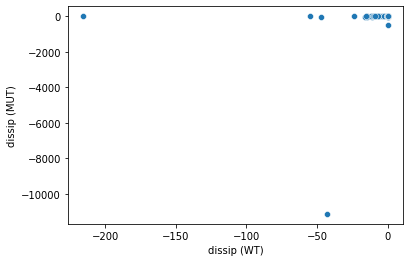

In [89]:
sns.scatterplot(data=r,x='dissip (WT)',y='dissip (MUT)')

In [96]:
m.reactions.get_by_id('PDH[condensed]')

Reaction identifier,PDH[condensed]
Name,
Memory address,0x07ff0de149cd0
Stoichiometry,coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c Coenzyme A + Nicotinamide adenine dinucleotide + Pyruvate --> Acetyl-CoA + CO2 + Nicotinamide adenine dinucleotide - reduced
GPR,(b0114 and b0115 and b0116)
Lower bound,0.0
Upper bound,1000.0


In [105]:
def isReactionCoenzymeCoupled(mets,reaction):
    coupled = False
    # determine if reaction is nad/nadh coupled
    nad_r = (mets['oxidant'] in reaction.metabolites) & (mets['reductant'] in reaction.metabolites)
    if nad_r:
        isbalanced = reaction.metabolites[mets['oxidant']] == -1* reaction.metabolites[mets['reductant']]
        if isbalanced:
            coupled = True
    return coupled

def getMetObj(model):

    # ensure all NAD(P)/NAD(P)H coupled reactions are reversible
    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    return met_objs

In [109]:
met_obj = getMetObj(cobra_model)
mets = {}
mets['oxidant'] = met_obj['nadp']
mets['reductant'] = met_obj['nadph']

nadp_coupled_reactions = []
for reaction in cobra_model.reactions:
    if isReactionCoenzymeCoupled(mets,reaction):
        nadp_coupled_reactions.append(reaction.id)

In [120]:
z = [x for x in r.index.get_level_values(0).tolist() if x in nadp_coupled_reactions]

In [137]:
tmodel_mut.objective.expression

1.0*Ec_biomass_iJO1366_WT_53p95M[condensed] - 1.0*Ec_biomass_iJO1366_WT_53p95M[condensed]_reverse_695c2

In [130]:
tmodel_mut_glut

Reaction identifier,GLUDy
Name,
Memory address,0x07ff0de1d3e80
Stoichiometry,glu-L_c + h2o_c + nadp_c <=> akg_c + h_c + nadph_c + nh4_c L-Glutamate + H2O + Nicotinamide adenine dinucleotide phosphate <=> 2-Oxoglutarate + H+ + Nicotinamide adenine dinucleotide phosphate - reduced + Ammonium
GPR,b1761
Lower bound,-1000.0
Upper bound,1000.0


In [47]:
from pytfa.optim import DeltaG
from pytfa.analysis.variability import calculate_dissipation

In [39]:
deltag_var = tmodel.get_variables_of_type(DeltaG)

In [51]:
reactions = calculate_dissipation(tmodel,solution).sort_values().dropna()

In [52]:
reactions

ACS          -3068.627275
PPKr         -1337.849765
CYTBO3_4pp    -382.484261
NADH16pp      -218.577457
ATPS4rpp       -87.333079
                 ...     
VALtex           0.000000
FE3tex           0.004378
ACALD            0.011010
FE2tex           0.046851
GLYCtpp          0.051780
Length: 416, dtype: float64

In [6]:
from cobra.manipulation.delete import prune_unused_metabolites
#m.metabolites

In [7]:
m,mets = prune_unused_metabolites(m)

In [56]:
max_solution = cobra_model.slim_optimize()
lb_growth_rate = max_solution*.9

In [57]:
m.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M[condensed]').lower_bound = lb_growth_rate

In [58]:
m.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M[condensed]')

Reaction identifier,Ec_biomass_iJO1366_WT_53p95M[condensed]
Name,
Memory address,0x07f986dbf4730
Stoichiometry,0.000223 10fthf_c + 0.000223 2dmmql8_c + 2.5e-05 2fe2s_c + 0.000248 4fe4s_c + 0.000223 5mthf_c + 0.000279 accoa_c + 0.000223 adocbl_c + 0.499149 ala-L_c + 0.000223 amet_c + 0.28742 arg-L_c +... 0.000223 10-Formyltetrahydrofolate + 0.000223 2-Demethylmenaquinol 8 + 2.5e-05 [2Fe-2S] iron-sulfur cluster + 0.000248 [4Fe-4S] iron-sulfur cluster + 0.000223 5-Methyltetrahydrofolate + 0.000279...
GPR,
Lower bound,0.7298659487967176
Upper bound,1000.0


In [59]:

# Load reaction DB
thermo_data = load_thermoDB(root_dir + 'data/thermo_data.thermodb')
lexicon = read_lexicon(root_dir + 'models/small_ecoli/lexicon.csv')
compartment_data = read_compartment_data(root_dir + 'models/small_ecoli/compartment_data.json')

# Initialize the model
tmodel = pytfa.ThermoModel(thermo_data, m)
tmodel.name = 'NAD_only'

# Annotate the model
annotate_from_lexicon(tmodel, lexicon)
apply_compartment_data(tmodel, compartment_data)

## TFA conversion
tmodel.prepare()
tmodel.convert()

2021-02-11 13:38:56,275 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-02-11 13:38:56,279 - thermomodel_None - INFO - # Model preparation starting...
2021-02-11 13:38:56,628 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-11 13:38:56,629 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-11 13:38:56,630 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-11 13:38:56,636 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-11 13:38:56,639 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-11 13:38:56,640 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-11 13:38:56,756 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-11 13:38:56,765 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-11 13:38:56,767 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-11 13:38:56,779 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-11 13:38:56,781 - thermomodel_None - WARNING - Warning : NULL/L
2021-02

In [13]:
nad_mets = [x for x in tmodel.LC_vars if 'Nicotinamide adenine dinucleotide' in x.name]

In [22]:
met_vars = {}
met_vars['nad'] = [x for x in nad_mets if x.id == 'nad_c'][0]
met_vars['nadh'] = [x for x in nad_mets if x.id == 'nadh_c'][0]
met_vars['nadp'] = [x for x in nad_mets if x.id == 'nadp_c'][0]
met_vars['nadph'] = [x for x in nad_mets if x.id == 'nadph_c'][0]

# define ratio expressions
nad_nadh_ratio = tmodel.LC_vars[met_vars['nad']]  - tmodel.LC_vars[met_vars['nadh']]
nadp_nadph_ratio = tmodel.LC_vars[met_vars['nadp']]  - tmodel.LC_vars[met_vars['nadph']]

tmodel.objective = nad_nadh_ratio
tmodel.objective.direction = 'max'
tmodel.slim_optimize()


In [23]:
tmodel.objective = nad_nadh_ratio
tmodel.objective.direction = 'max'
tmodel.slim_optimize()

In [25]:
tmodel.slim_optimize()

10.819778284410283

In [182]:
solution = tmodel.optimize()

In [173]:
#tmodel.reactions.get_by_id('𝑏𝑖𝑜𝑚𝑎𝑠𝑠𝑖𝐽𝑂1366𝑊𝑇53𝑝95𝑀[𝑐𝑜𝑛𝑑𝑒𝑛𝑠𝑒𝑑]𝑟𝑒𝑣𝑒𝑟𝑠𝑒695𝑐2')
[x for x in tmodel.variables if 'Ec_biomass_iJO1366_WT_53p95M' in x.name]

[0 <= Ec_biomass_iJO1366_WT_53p95M[condensed] <= 1000.0,
 0 <= Ec_biomass_iJO1366_WT_53p95M[condensed]_reverse_695c2 <= 1000,
 0 <= FU_Ec_biomass_iJO1366_WT_53p95M[condensed] <= 1,
 0 <= BU_Ec_biomass_iJO1366_WT_53p95M[condensed] <= 1]

In [154]:
#help(tmodel.problem)
#pytfa.analysis.variability._variability_analysis_element(tmodel, var, sense)

-13.815510557964274

In [194]:
# 
m2_obj = m2.copy()
m2_obj.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M[condensed]').lower_bound = 0.8

In [199]:
# add constraint 

# Load reaction DB
thermo_data = load_thermoDB(root_dir + 'data/thermo_data.thermodb')
lexicon = read_lexicon(root_dir + 'models/small_ecoli/lexicon.csv')
compartment_data = read_compartment_data(root_dir + 'models/small_ecoli/compartment_data.json')

# Initialize the model
tmodel_obj = pytfa.ThermoModel(thermo_data, m2_obj)
tmodel_obj.name = 'NAD_only'

# Annotate the model
annotate_from_lexicon(tmodel_obj, lexicon)
apply_compartment_data(tmodel_obj, compartment_data)

## TFA conversion
tmodel_obj.prepare()
tmodel_obj.convert()

2021-02-10 20:52:33,300 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-02-10 20:52:33,319 - thermomodel_None - INFO - # Model preparation starting...
2021-02-10 20:52:33,625 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-10 20:52:33,626 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-10 20:52:33,630 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-10 20:52:33,639 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-10 20:52:33,645 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-10 20:52:33,650 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-10 20:52:33,705 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-10 20:52:33,705 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-10 20:52:33,706 - thermomodel_None - WARNING - Warning : NULL/L
2021-02-10 20:52:33,708 - thermomodel_None - WARNING - Warning : NULL/U
2021-02-10 20:52:33,713 - thermomodel_None - WARNING - Warning : NULL/L
2021-02

In [203]:
#[x for x in names if 'LC_nad_c' in x]
var = [x for x in tmodel_obj.variables if 'LC_nad_c' in x.name][0]
sense = 'max'
pytfa.analysis.variability._variability_analysis_element(tmodel_obj, var, sense)

-2.995732273553991

In [ ]:
#[x for x in names if 'LC_nad_c' in x]
var = [x for x in tmodel_obj.variables if 'LC_nad_c' in x.name][0]
sense = 'min'
pytfa.analysis.variability._variability_analysis_element(tmodel_obj, var, sense)

In [ ]:
a= 1

In [63]:
#analysis.variability_analysis(tmodel,kind='reactions')
#tmodel.get_variables_of_type()
tmodel.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,DM_ca2_e,0.004016,0,0.00%
cbl1_e,DM_cbl1_e,0.0001809,62,0.02%
cl_e,DM_cl_e,0.004016,0,0.00%
cobalt2_e,DM_cobalt2_e,1.946E-05,0,0.00%
cu2_e,DM_cu2_e,0.0005466,0,0.00%
fe2_e,DM_fe2_e,0.006568,0,0.00%
fe3_e,DM_fe3_e,0.006024,0,0.00%
glc-D_e,DM_glc_e,8.16,6,94.20%
glycogenn1_c,DM_glycogenn1_c,0.125,24,5.77%
k_e,DM_k_e,0.1506,0,0.00%


In [52]:
var_opt = 'LC_nad_c'
analysis.variability._variability_analysis_element(tmodel,var_opt,1)

ValueError: invalid objective

In [56]:
tmodel.objective = 'Ec_biomass_iJO1366_WT_53p95M[condensed]'

In [59]:
tmodel.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M[condensed]')

Reaction identifier,Ec_biomass_iJO1366_WT_53p95M[condensed]
Name,
Memory address,0x07f8555cc50a0
Stoichiometry,0.000223 10fthf_c + 0.000223 2dmmql8_c + 2.5e-05 2fe2s_c + 0.000248 4fe4s_c + 0.000223 5mthf_c + 0.000279 accoa_c + 0.000223 adocbl_c + 0.499149 ala-L_c + 0.000223 amet_c + 0.28742 arg-L_c +... 0.000223 10-Formyltetrahydrofolate + 0.000223 2-Demethylmenaquinol 8 + 2.5e-05 _2Fe-2S iron-sulfur cluster + 0.000248 _4Fe-4S iron-sulfur cluster + 0.000223 5-Methyltetrahydrofolate + 0.000279...
GPR,
Lower bound,0.0
Upper bound,1000.0
